In [1]:
%cd ..

/home/eli/AnacondaProjects/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer
import utils

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
from utils import read_json

config = read_json("experiments/ppc_mnist_config.json")
config = ConfigParser(config)

In [7]:
logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of metrics
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer.
optimizer = config.init_obj('optimizer', pyro.optim)

# build trainer
# kwargs = config['trainer'].pop('args')
trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                          config=config, data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=None)

trainer._resume_checkpoint("saved/models/Mnist_Ppc/0416_172629/checkpoint-epoch2000.pth")

MnistPpc(
  (prior): GaussianPrior()
  (decoder1): ConditionalGaussian(
    (decoder): Sequential(
      (0): ReLU()
      (1): Linear(in_features=20, out_features=128, bias=True)
    )
  )
  (decoder2): ConditionalGaussian(
    (decoder): Sequential(
      (0): ReLU()
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
  )
  (likelihood): MlpBernoulliLikelihood(
    (decoder): Sequential(
      (0): ReLU()
      (1): Linear(in_features=256, out_features=784, bias=True)
    )
  )
  (graph): PpcGraphicalModel()
)
Trainable parameters: 319540
Initialize particles: train batch 0
Initialize particles: train batch 1
Initialize particles: train batch 2
Initialize particles: train batch 3
Initialize particles: train batch 4
Initialize particles: train batch 5
Initialize particles: train batch 6
Initialize particles: train batch 7
Initialize particles: train batch 8
Initialize particles: train batch 9
Initialize particles: train batch 10
Initialize particles: train batch 11
I

In [8]:
trainer.model.eval()
trainer.cpu()
trainer.valid_particles.cpu()

ParticleDict(
    (z1): Parameter containing: [torch.FloatTensor of size 4x6000x20]
    (z2): Parameter containing: [torch.FloatTensor of size 4x6000x128]
    (z3): Parameter containing: [torch.FloatTensor of size 4x6000x256]
)

In [9]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [10]:
SEEDS = [123, 456, 789, 101112, 131415]

In [11]:
import utils

In [12]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [13]:
for (s, SEED) in enumerate(SEEDS):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    for (xs, target, indices) in trainer.valid_data_loader:
        trainer._load_particles(indices, False)
    
        with pyro.plate_stack("forward", (trainer.num_particles, len(xs))):
            model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
            x_hats = model().mean(dim=0)
        LOG_LIKELIHOODS[s] += -torch.nn.functional.binary_cross_entropy(x_hats, xs, reduction="none").sum()
        MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean()

    LOG_LIKELIHOODS[s] /= len(trainer.valid_data_loader.sampler)
    MEAN_SQUARED_ERROR[s] /= len(trainer.valid_data_loader.sampler)

In [14]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-100.8156, grad_fn=<MeanBackward0>),
 tensor(0.0173, grad_fn=<StdBackward0>))

In [15]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0087, grad_fn=<MeanBackward0>),
 tensor(5.1404e-06, grad_fn=<StdBackward0>))

In [16]:
import matplotlib.pyplot as plt

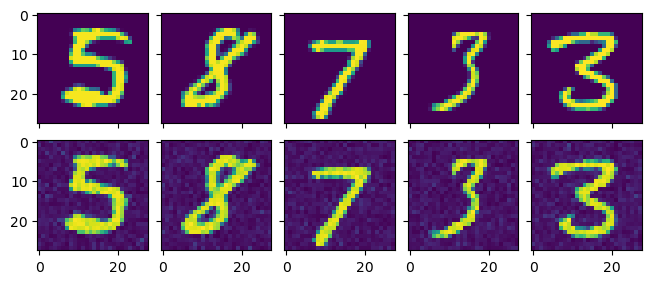

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex="all", sharey="all", layout="compressed")

for i in range(5):
    axes[0, i].imshow(xs[i].squeeze().detach().numpy())
    axes[1, i].imshow(x_hats[i].squeeze().detach().numpy())

fig.savefig("ppc_mnist_recons.pdf", bbox_inches="tight")
plt.show()

In [18]:
trainer._clear_particles()

In [19]:
trainer._valid_epoch(2000)

{'loss': -1548.421407063802,
 'ess': 3.713394284248352,
 'log_marginal': 1548.6062418619792,
 'log_joint': 1752.6422932942708}